import modules

In [2]:
from typing import Tuple
import numpy as np
import torch as t
from torch.distributions import uniform
from diffusion import diffuse
from diffusion_gumbel import diffuse_STE
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm

define helper function to pre-process data

In [3]:
def chop_and_shuffle_data(sequence, shuffle=True):
    """
    Chop the training data into a set of state transitions and shuffle the resulting set.

    sequences (np.ndarray): matrix of shape (n_sequences, steps_per_seq, grid_height, grid_width)
    """
    steps_per_seq, _, grid_height, grid_width = sequence.shape
    # each transition consists of 2 states
    indexer = np.arange(2)[None, :] + np.arange(steps_per_seq - 1)[:, None]
    chopped_set = np.zeros(
        [(steps_per_seq - 1), 2, 2, grid_height, grid_width]
    )
    chopped_set = sequence.detach().numpy()[indexer]
    if shuffle:
        np.random.shuffle(chopped_set)
    return t.tensor(chopped_set)

generate data

In [4]:
grid = t.zeros((2,30,30))
grid[:] = 50
grid[0,12:17] = 90
N = 100 
num_steps = 1_000
DA = 0.1
DB = 0.4
t.sum(grid[0])

tensor(51000.)

In [5]:
grid = grid.float()
sequence = t.zeros((num_steps, *grid.shape))

for i in tqdm(range(num_steps)):
    sequence[i] = grid.detach().clone()
    #display.clear_output(wait=True)
    #plt.cla()
    #plt.imshow(grid[0].cpu(), cmap="Greys", interpolation="nearest", vmin=0, vmax=100)
    #display.display(plt.gcf())
    grid = diffuse(grid, N, DA, DB)

  0%|          | 0/1000 [00:00<?, ?it/s]/root/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 1000/1000 [00:01<00:00, 678.79it/s]


In [6]:
sequence.shape

torch.Size([1000, 2, 30, 30])

In [7]:
dataset = chop_and_shuffle_data(sequence=sequence)

In [8]:
dataset.shape

torch.Size([999, 2, 2, 30, 30])

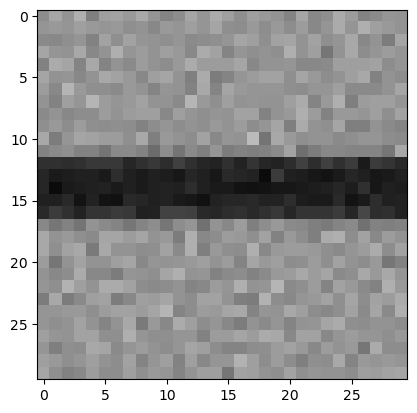

In [9]:
plt.imshow(dataset[998,0,0].cpu(), cmap="Greys", interpolation="nearest", vmin=0, vmax=100)

In [10]:
def MSE(X, Y):
    return t.mean(t.sum((X-Y)**2, dim=((1,2,3))))

In [11]:
X = dataset[:,0]
Y_obs = dataset[:,1]
print(MSE(X,Y_obs))

tensor(217.8819)


In [12]:
def dist(X, D1, D2):
    mse_D1 = MSE(X, D1)
    #print(mse_D1)
    mse_D2 = MSE(X, D2)
    #print(mse_D2)
    return (mse_D1 - mse_D2)**2

In [30]:
print(dist(X, Y_obs, Y_obs))

tensor(0., device='cuda:0')


visualizing the gradient for a single diffusion coefficient

In [ ]:
D_A = t.tensor(0.1)
D_A.requires_grad_()
D_B = t.tensor(0.4)
X = dataset[:,0]
Y_sim = diffuse_STE(X, N, D_A, D_B)
val = dist(X, Y_obs, Y_sim)
print(val)

In [14]:
t.autograd.grad(val, D_A)

(tensor(-131.4033),)

In [13]:
DA_vals = t.linspace(0.0, 1.0, 100)
X = dataset[:,0]
Y_obs = dataset[:,1]
DB_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
grads = []
distances = []
for DB in tqdm(DB_vals):
    distances_cur = []
    grads_cur = []
    for DA in DA_vals:
        DA.requires_grad_()
        Y_sim = diffuse_STE(X, N, DA, t.tensor(0.4))
        dist_val = dist(X, Y_sim, Y_obs)
        distances_cur.append(dist_val.detach().numpy())
        gradient = t.autograd.grad(dist_val, DA)[0]
        grads_cur.append(gradient.detach().numpy())
    distances.append(distances_cur)
    grads.append(grads_cur)

100%|██████████| 9/9 [08:47<00:00, 58.62s/it]


/tmp/ipykernel_88703/2213780703.py:3: RuntimeWarning: invalid value encountered in log
  axs[1].plot(DA_vals, np.log(np.array(grads[idx])), label=f"D_B: {DB_vals[idx]}")


AttributeError: 'AxesSubplot' object has no property 'ticks'

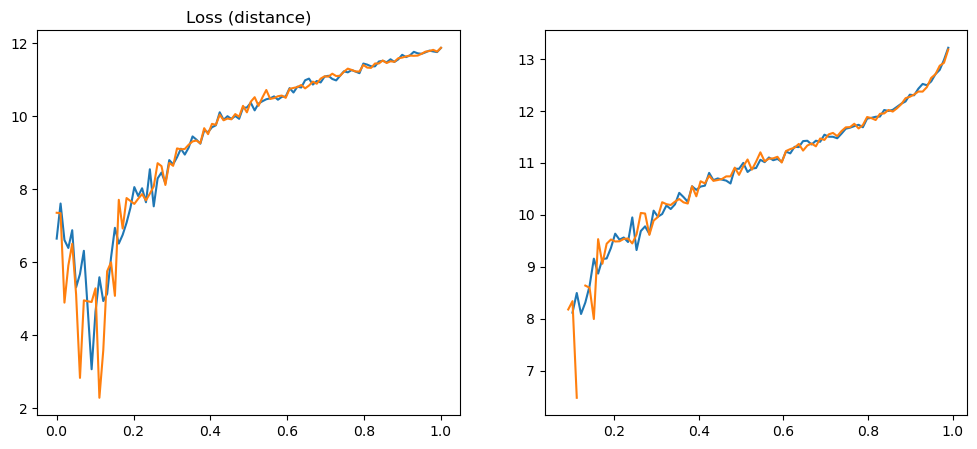

In [24]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
for idx in range(2):
    axs[1].plot(DA_vals, np.log(np.array(grads[idx])), label=f"D_B: {DB_vals[idx]}")
    axs[0].plot(DA_vals, np.log(np.array(distances[idx])), label=f"D_B: {DB_vals[idx]}")
axs[0].set(title="Loss (distance)")
axs[1].set(title="Gradients")

plt.legend()

In [23]:
grads[1]

[array(nan, dtype=float32),
 array(-11575.361, dtype=float32),
 array(-3794.9878, dtype=float32),
 array(-6142.575, dtype=float32),
 array(-7528.71, dtype=float32),
 array(-3323.75, dtype=float32),
 array(-1168.2351, dtype=float32),
 array(-2983.9517, dtype=float32),
 array(-2416.7817, dtype=float32),
 array(3560.1401, dtype=float32),
 array(4180.0703, dtype=float32),
 array(650.239, dtype=float32),
 array(-1307.3562, dtype=float32),
 array(5640.699, dtype=float32),
 array(5409.0566, dtype=float32),
 array(2963.0938, dtype=float32),
 array(13791.876, dtype=float32),
 array(8581.985, dtype=float32),
 array(12628.044, dtype=float32),
 array(13698.666, dtype=float32),
 array(13189.028, dtype=float32),
 array(13230.082, dtype=float32),
 array(13852.1875, dtype=float32),
 array(13957.508, dtype=float32),
 array(12702.617, dtype=float32),
 array(15087.504, dtype=float32),
 array(22836.822, dtype=float32),
 array(22585.105, dtype=float32),
 array(14967.221, dtype=float32),
 array(19709.479, d

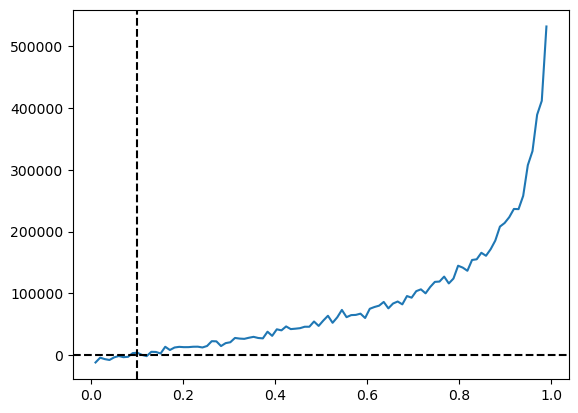

In [21]:
plt.plot(DA_vals, grads[1])
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.axvline(x = 0.1, color = 'black', linestyle = '--')

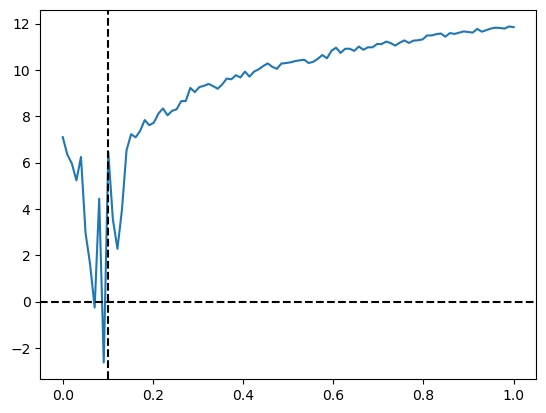

In [18]:
plt.plot(DA_vals.cpu(), np.log(np.array(distances)))
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.axvline(x = 0.1, color = 'black', linestyle = '--')

visualizing the gradient of both diffusion coefficients

In [47]:
DA_vals = t.linspace(0.00001, 0.99999, 100)
DA_vals = DA_vals.cuda()

DB_vals = t.linspace(0.00001, 0.99999, 100)
DB_vals = DB_vals.cuda()

grid_DA, grid_DB = t.meshgrid(DA_vals, DB_vals, indexing="ij")

print(grid_DA.shape)
print(grid_DB.shape)

#for i in range(grid_DA.shape[0]):
#    for j in range(grid_DB.shape[0]):
#        print(f"{grid_DA[i,j]} {grid_DB[i,j]}")

torch.Size([100, 100])
torch.Size([100, 100])


In [49]:
X = dataset[:,0]
X = X.cuda()
Y_obs = dataset[:,1]
Y_obs = Y_obs.cuda()
grads_DA = []
grads_DB = []
distances = []
for i in range(grid_DA.shape[0]):
    for j in tqdm(range(grid_DB.shape[0])):
        DA = grid_DA[i,j]
        DA.requires_grad_()
        DB = grid_DB[i,j]
        DB.requires_grad_()
        Y_sim = diffuse_STE(X, N, DA, DB)
        dist_val = dist(X, Y_sim, Y_obs)
        grad_DA, grad_DB = t.autograd.grad(dist_val, (DA, DB))
        grads_DA.append(grad_DA.detach().clone().cpu().numpy())
        grads_DB.append(grad_DB.detach().clone().cpu().numpy())
        distances.append(dist_val.detach().clone().cpu().numpy())

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


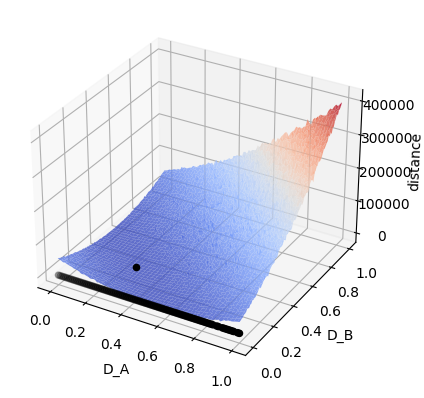

In [101]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "computed_zorder": False})
ax.plot_surface(grid_DA.cpu(), grid_DB.cpu(), np.array(distances).reshape(100,100), cmap=cm.coolwarm, alpha=0.8)
ax.set(xlabel="D_A", ylabel="D_B", zlabel="distance")

x, y = np.where(np.array(distances).reshape(100,100) == np.amin(distances))
ax.scatter(grid_DA[x[0], y[0]].cpu(), grid_DB[x[0], y[0]].cpu(), np.amin(distances), color="black")

x, y = np.where(np.array(grads_DB).reshape(100,100) == 0)
ax.scatter(grid_DA[x, y].cpu(), grid_DB[x, y].cpu(), 0, color="black")
plt.draw()


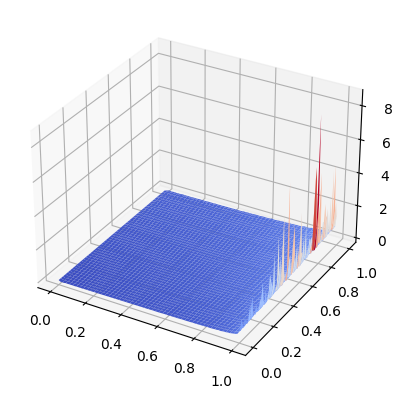

In [112]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "computed_zorder": False})
ax.plot_surface(grid_DA.cpu(), grid_DB.cpu(), np.array(grads_DA).reshape(100,100), cmap=cm.coolwarm, alpha=1)
plt.draw()

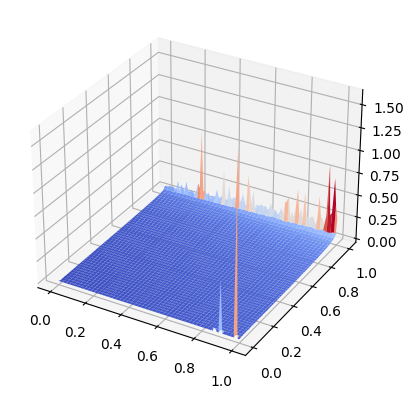

In [113]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "computed_zorder": False})
ax.plot_surface(grid_DA.cpu(), grid_DB.cpu(), np.array(grads_DB).reshape(100,100), cmap=cm.coolwarm, alpha=1)
plt.draw()

test

In [114]:
DA_vals = t.linspace(0.0, 1.0, 1000)
DA_vals = DA_vals.cuda()
X = dataset[:,0]
X = X.cuda()
Y_obs = dataset[:,1]
Y_obs = Y_obs.cuda()
grads = []
for DA in tqdm(DA_vals):
    DA.requires_grad_()
    Y_sim = diffuse_STE(X, N, DA, t.tensor(0.1))
    dist_val = dist(X, Y_sim, Y_obs)
    gradient = t.autograd.grad(dist_val, DA)[0]
    grads.append(gradient.detach().clone())

100%|██████████| 1000/1000 [08:21<00:00,  2.00it/s]


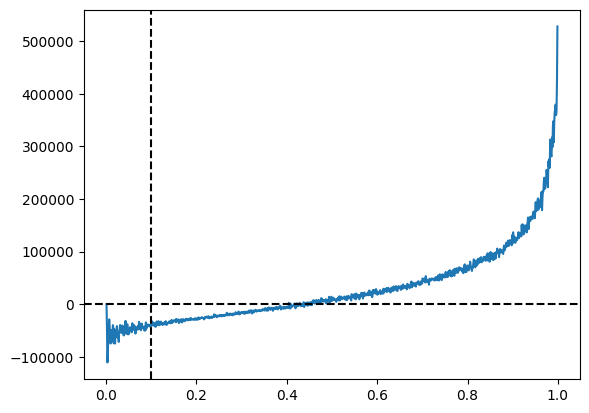

In [115]:
plt.plot(DA_vals.cpu(), t.tensor(grads).cpu())
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.axvline(x = 0.1, color = 'black', linestyle = '--')

In [116]:
DA_vals = t.linspace(0.0, 1.0, 1000)
DA_vals = DA_vals.cuda()
X = dataset[:,0]
X = X.cuda()
Y_obs = dataset[:,1]
Y_obs = Y_obs.cuda()
grads = []
for DA in tqdm(DA_vals):
    DA.requires_grad_()
    Y_sim = diffuse_STE(X, N, DA, t.tensor(0.2))
    dist_val = dist(X, Y_sim, Y_obs)
    gradient = t.autograd.grad(dist_val, DA)[0]
    grads.append(gradient.detach().clone())

100%|██████████| 1000/1000 [08:40<00:00,  1.92it/s]


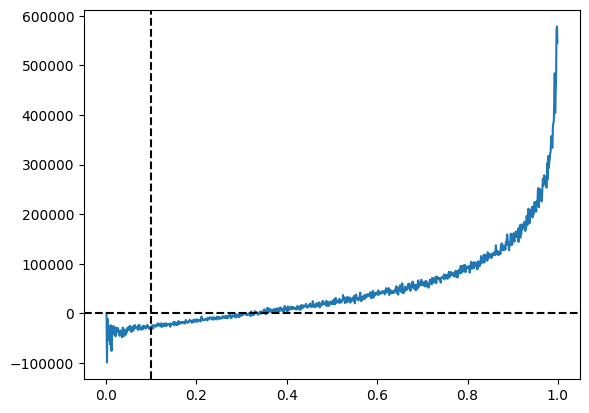

In [117]:
plt.plot(DA_vals.cpu(), t.tensor(grads).cpu())
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.axvline(x = 0.1, color = 'black', linestyle = '--')

adding reaction

In [5]:
from reaction_ste import rho_STE
from reaction import p1, p2, p3, p4, p5, p6, rho

In [6]:
grid = t.zeros((2,15,15))
grid[:] = 50
grid[0,12:17] = 90
N = 100 
gamma = 0.005 
rate_coefficients = t.tensor([0.98,0.98,0.1,0.1,0.2,0.2])
probability_funcs = [p1,p2,p3,p4,p5,p6]
num_steps = 1_000
DA = 0.1
DB = 0.4
t.sum(grid[0])

tensor(13050.)

In [7]:
grid = grid.float()
sequence = t.zeros((num_steps, *grid.shape))

for i in tqdm(range(num_steps)):
    sequence[i] = grid.detach().clone()
    #display.clear_output(wait=True)
    #plt.cla()
    #plt.imshow(grid[0].cpu(), cmap="Greys", interpolation="nearest", vmin=0, vmax=100)
    #display.display(plt.gcf())
    grid = diffuse(grid, N, DA, DB)
    grid = rho(grid, N, gamma, rate_coefficients, probability_funcs, num_reaction_channels=6)

  0%|          | 0/1000 [00:00<?, ?it/s]/root/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 1000/1000 [00:04<00:00, 223.02it/s]


In [10]:
dataset = chop_and_shuffle_data(sequence=sequence)

In [ ]:
DA_vals = t.linspace(0.0, 1.0, 1000)
#DA_vals = t.tensor([0.3])
X = dataset[:,0]
#X = X.cuda()
Y_obs = dataset[:,1]
#Y_obs = Y_obs.cuda()
t.autograd.set_detect_anomaly(False)
grads = []
for DA in tqdm(DA_vals):
    DA.requires_grad_()
    diffused = diffuse_STE(X, N, DA, t.tensor(0.4))
    diffused.retain_grad()
    Y_sim = rho_STE(diffused, N, gamma, rate_coefficients, probability_funcs, num_reaction_channels=6)
    dist_val = dist(X, Y_sim, Y_obs)
    gradient = t.autograd.grad(dist_val, DA)[0]
    grads.append(gradient.detach().clone())

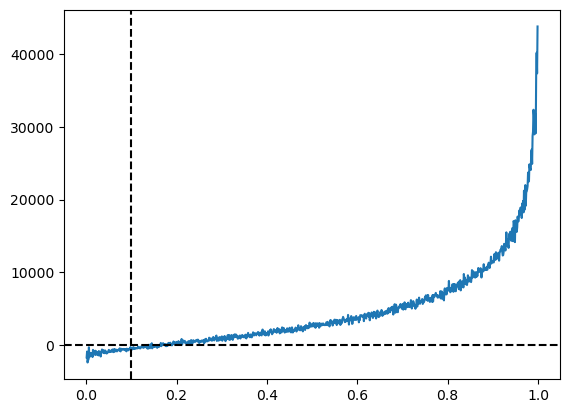

In [16]:
plt.plot(DA_vals.cpu(), t.tensor(grads).cpu())
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.axvline(x = 0.1, color = 'black', linestyle = '--')

test differentiating through reaction coefficients

In [1]:
from typing import Tuple
import numpy as np
import torch as t
from torch.distributions import uniform
from diffusion import diffuse
from diffusion_gumbel import diffuse_STE
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm
from reaction_ste import rho_STE
from reaction import p1, p2, p3, p4, p5, p6, rho

In [2]:
def MSE(X, Y):
    return t.mean(t.sum((X-Y)**2, dim=((1,2,3))))

In [3]:
def dist(X, D1, D2):
    mse_D1 = MSE(X, D1)
    #print(mse_D1)
    mse_D2 = MSE(X, D2)
    #print(mse_D2)
    return (mse_D1 - mse_D2)**2

In [4]:
def chop_and_shuffle_data(sequence, shuffle=True):
    """
    Chop the training data into a set of state transitions and shuffle the resulting set.

    sequences (np.ndarray): matrix of shape (n_sequences, steps_per_seq, grid_height, grid_width)
    """
    steps_per_seq, _, grid_height, grid_width = sequence.shape
    # each transition consists of 2 states
    indexer = np.arange(2)[None, :] + np.arange(steps_per_seq - 1)[:, None]
    chopped_set = np.zeros(
        [(steps_per_seq - 1), 2, 2, grid_height, grid_width]
    )
    chopped_set = sequence.detach().numpy()[indexer]
    if shuffle:
        np.random.shuffle(chopped_set)
    return t.tensor(chopped_set)

In [5]:
grid = t.zeros((2,15,15))
grid[:] = 50
grid[0,12:17] = 90
N = 100 
gamma = 0.005 
rate_coefficients = t.tensor([0.98,0.98,0.1,0.1,0.2,0.2])
probability_funcs = [p1,p2,p3,p4,p5,p6]
num_steps = 1_000
DA = 0.1
DB = 0.4
t.sum(grid[0])

tensor(13050.)

In [6]:
grid = grid.float()
sequence = t.zeros((num_steps, *grid.shape))

for i in tqdm(range(num_steps)):
    sequence[i] = grid.detach().clone()
    #display.clear_output(wait=True)
    #plt.cla()
    #plt.imshow(grid[0].cpu(), cmap="Greys", interpolation="nearest", vmin=0, vmax=100)
    #display.display(plt.gcf())
    grid = diffuse(grid, N, DA, DB)
    grid = rho(grid, N, gamma, rate_coefficients, probability_funcs, num_reaction_channels=6)

  0%|          | 0/1000 [00:00<?, ?it/s]/root/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 1000/1000 [00:04<00:00, 233.26it/s]


In [7]:
dataset = chop_and_shuffle_data(sequence=sequence)

In [8]:
K1_vals = t.linspace(0.0001, 0.99999, 1000)
rate_coefficients = t.tensor([0.98,0.98,0.1,0.1,0.2,0.2])
probability_funcs = [p1,p2,p3,p4,p5,p6]
num_steps = 1_000
t.sum(grid[0])

tensor(13251.)

In [13]:
X = dataset[:,0]
#X = X.cuda()
Y_obs = dataset[:,1]
#Y_obs = Y_obs.cuda()
t.autograd.set_detect_anomaly(False)
grads = []
for K1 in tqdm(K1_vals):
    rate_coefficients = t.tensor([K1,0.98,0.1,0.1,0.2,0.2])
    rate_coefficients.requires_grad_()
    diffused = diffuse_STE(X, N, t.tensor(0.1), t.tensor(0.4))
    Y_sim = rho_STE(diffused, N, gamma, rate_coefficients, probability_funcs, num_reaction_channels=6)
    Y_sim.retain_grad()
    dist_val = dist(X, Y_sim, Y_obs)
    gradient = t.autograd.grad(dist_val, rate_coefficients)[0]
    grads.append(gradient.detach().clone())

  0%|          | 0/1000 [00:00<?, ?it/s]/root/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
  0%|          | 0/1000 [06:50<?, ?it/s]


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.